In [94]:
import pandas as pd
import numpy as np
import pickle
import time 
import os
from datetime import datetime
from operator import itemgetter
import time

# 需要什么读取什么不要一次性全都读取了，影响程序速度

data_folder_path = '../'
raw_data_path = "../raw_data"
storage_path = "../database_storage"
daily_path = "../daily"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")
DCBS_path = os.path.join(storage_path, "DCBS.pkl")

with open('database_ByZCG\\DCBS_DataFrame.pkl', 'rb') as f: 
    DCBS_DataFrame = pickle.load(f)
    
with open('database_ByZCG\\DTBS_DataFrame.pkl', 'rb') as f:  
    DTBS_DataFrame = pickle.load(f)

# 只提取A区中存活的转债的时间序列信息
A_DF = DTBS_DataFrame['A']
A_DF = A_DF[A_DF['ia']==1].copy()
B_DF = DTBS_DataFrame['B'].copy()
C_DF = DTBS_DataFrame['C'].copy()
D_DF = DTBS_DataFrame['D'].copy()
E_DF = DTBS_DataFrame['E'].copy()

In [95]:
print(E_DF)

                     stock_code        date     cl      pb      zyl
id                                                                 
002360.SZ,2017-01-03  002360.SZ  2017-01-03  12.30  4.8859  30.9905
002360.SZ,2017-01-04  002360.SZ  2017-01-04  12.41  4.9296  30.9905
002360.SZ,2017-01-05  002360.SZ  2017-01-05  12.44  4.9415  30.9905
002360.SZ,2017-01-06  002360.SZ  2017-01-06  12.24  4.8620  30.9905
002360.SZ,2017-01-09  002360.SZ  2017-01-09  12.54  4.9812  30.9905
...                         ...         ...    ...     ...      ...
688678.SH,2023-09-05  688678.SH  2023-09-05   0.00  0.0000      NaN
688678.SH,2023-09-06  688678.SH  2023-09-06   0.00  0.0000      NaN
688678.SH,2023-09-07  688678.SH  2023-09-07   0.00  0.0000      NaN
688678.SH,2023-09-08  688678.SH  2023-09-08   0.00  0.0000      NaN
688678.SH,2023-09-11  688678.SH  2023-09-11   0.00  0.0000      NaN

[1251072 rows x 5 columns]


                      bond_code        date      cpr       dp         bl  \
id                                                                         
110043.SH,2023-01-03  110043.SH  2023-01-03  15.8286  111.989  29.213300   
110043.SH,2023-01-04  110043.SH  2023-01-04  13.1610  114.203  29.213300   
110043.SH,2023-01-05  110043.SH  2023-01-05  13.1415  114.600  29.213300   
110043.SH,2023-01-06  110043.SH  2023-01-06  14.5470  114.758  29.213300   
110043.SH,2023-01-09  110043.SH  2023-01-09  16.0277  114.532  29.213300   
...                         ...         ...      ...      ...        ...   
128145.SZ,2023-02-17  128145.SZ  2023-02-17  -0.8436  132.050   1.532941   
128145.SZ,2023-02-20  128145.SZ  2023-02-20  -0.7001  131.670   1.187342   
128145.SZ,2023-02-21  128145.SZ  2023-02-21  -0.3236  130.449   1.099123   
128145.SZ,2023-02-22  128145.SZ  2023-02-22  -0.5313  127.030   0.976149   
128145.SZ,2023-02-23  128145.SZ  2023-02-23  -0.2378  125.205   0.773509   

           

<Figure size 1500x1500 with 0 Axes>

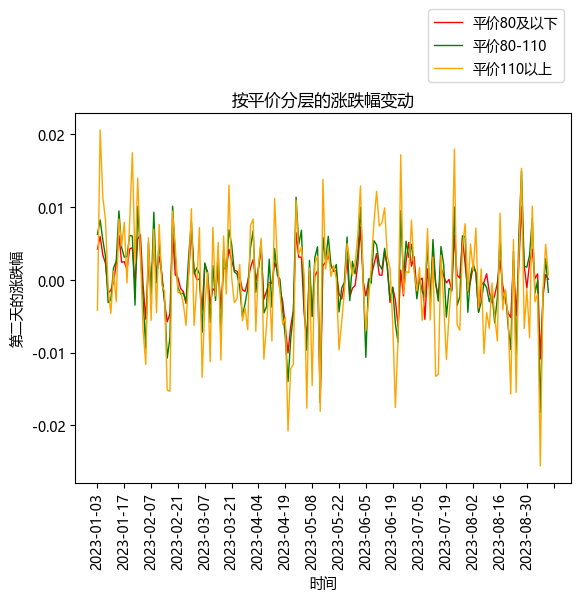

每天按平价分层买入的累计收益率：
2.4 %
6.67 %
-6.66 %


In [96]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt,log
from numpy import std

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

start_day = '2023-01-01'
a_df = A_DF[A_DF['date']>=start_day].copy()
c_df = C_DF[C_DF['date']>=start_day][['date','zi', 'gz2000']].copy()

x = list(C_DF[C_DF['date']>=start_day]['date'])


a_df.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
a_df['后1个交易日的价格'] = a_df.groupby('bond_code')['dp'].shift(-1)

a_df = a_df[~a_df['后1个交易日的价格'].isnull()].copy()

print(a_df)

csv_80 = a_df[a_df['csv'] <= 80].groupby('date')['后1个交易日的价格'].sum() / a_df[a_df['csv'] <= 80].groupby('date')['dp'].sum() - 1
csv_80_110 = a_df[(a_df['csv'] > 80) & (a_df['csv'] <= 110)].groupby('date')['后1个交易日的价格'].sum() / a_df[(a_df['csv'] > 80) & (a_df['csv'] <= 110)].groupby('date')['dp'].sum() - 1
csv_110 = a_df[a_df['csv'] > 110].groupby('date')['后1个交易日的价格'].sum() / a_df[a_df['csv'] > 110].groupby('date')['dp'].sum() - 1


# 绘图
plt.figure(figsize=(15,15))
fig, ax = plt.subplots(1, 1)
plt.plot(x[:-1], csv_80, color='red', label="平价80及以下",linewidth=1)
plt.plot(x[:-1], csv_80_110, color='green', label="平价80-110",linewidth=1)
plt.plot(x[:-1], csv_110, color='orange', label="平价110以上",linewidth=1)
plt.xlabel("时间")
plt.ylabel("第二天的涨跌幅")
plt.title('按平价分层的涨跌幅变动')
# 图例显示
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.3))
# 设置打印的密度
tick_spacing = 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# 设置显示字体的大小
plt.tick_params(axis='both', labelsize=10)
# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)
# 显示图像
plt.show()


def calculate(profit):
    result = 1
    for i in profit:
        result = result * (i + 1)
    return round((result - 1) * 100, 2)

print('每天按平价分层买入的累计收益率：')
print(calculate(list(csv_80)),'%')
print(calculate(list(csv_80_110)),'%')
print(calculate(list(csv_110)),'%')

date
2023-01-03     83
2023-01-04     88
2023-01-05     92
2023-01-06     94
2023-01-09     90
             ... 
2023-09-06    122
2023-09-07    121
2023-09-08    125
2023-09-11    112
2023-09-12    112
Name: dp, Length: 170, dtype: int64
date
2023-01-03    177
2023-01-04    177
2023-01-05    176
2023-01-06    175
2023-01-09    181
             ... 
2023-09-06    178
2023-09-07    183
2023-09-08    185
2023-09-11    188
2023-09-12    198
Name: dp, Length: 170, dtype: int64
date
2023-01-03    13
2023-01-04    16
2023-01-05    16
2023-01-06    13
2023-01-09    13
              ..
2023-09-06    14
2023-09-07    17
2023-09-08    18
2023-09-11    18
2023-09-12    19
Name: dp, Length: 170, dtype: int64


<Figure size 1500x1500 with 0 Axes>

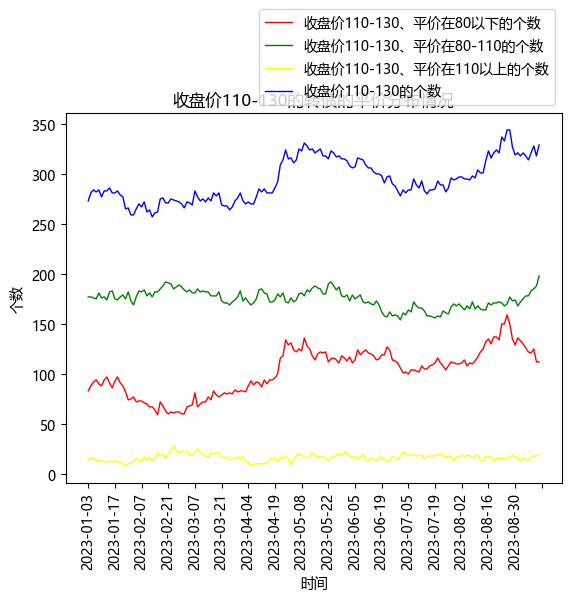

In [97]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt,log
from numpy import std

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

start_day = '2023-01-01'
a_df = A_DF[A_DF['date']>=start_day].copy()
c_df = C_DF[C_DF['date']>=start_day][['date','zi', 'gz2000']].copy()

x = list(C_DF[C_DF['date']>=start_day]['date'])

temp_df = a_df[(a_df['dp'] >= 110) & (a_df['dp'] <= 130)].copy()

print(temp_df[temp_df['csv'] < 80].groupby('date')['dp'].count())
print(temp_df[(temp_df['csv'] >= 80) & (temp_df['csv'] <= 110)].groupby('date')['dp'].count())
print(temp_df[temp_df['csv'] > 110].groupby('date')['dp'].count())

# 绘图
plt.figure(figsize=(15,15))
fig, ax = plt.subplots(1, 1)
plt.plot(x, temp_df[temp_df['csv'] < 80].groupby('date')['dp'].count(), color='red', label="收盘价110-130、平价在80以下的个数",linewidth=1)
plt.plot(x, temp_df[(temp_df['csv'] >= 80) & (temp_df['csv'] <= 110)].groupby('date')['dp'].count(), color='green', label="收盘价110-130、平价在80-110的个数",linewidth=1)
plt.plot(x, temp_df[temp_df['csv'] > 110].groupby('date')['dp'].count(), color='yellow', label="收盘价110-130、平价在110以上的个数",linewidth=1)
plt.plot(x, temp_df.groupby('date')['dp'].count(), color='blue', label="收盘价110-130的个数",linewidth=1)

plt.xlabel("时间")
plt.ylabel("个数")
plt.title('收盘价110-130的转债的平价分布情况')
# 图例显示
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.3))
# 设置打印的密度
tick_spacing = 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# 设置显示字体的大小
plt.tick_params(axis='both', labelsize=10)
# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)
# 显示图像
plt.show()


output_df = temp_df[(temp_df['csv'] < 80) & (temp_df['date'] == '2023-09-12')].copy()
output_df = pd.merge(output_df, B_DF[['bond_code', 'cn', 'sc', 'sn']], on='bond_code', how='left')
output_df.rename(columns={'date' : '日期',
                                'bond_code' : '可转债代码',
                                'cn' : '可转债名称',
                                'sc' : '正股代码',
                                'sn' : '正股名称',
                                'dp' : '价格',
                                'cpr' : '转股溢价率',
                                'dl' : '双低',
                                'change':'涨跌幅',
                                'bl' : '债券余额（亿）',
                                'yl' : '剩余期限（年）'},inplace=True)
output_df.to_excel('平价80以下.xlsx',index=False)

<Figure size 1500x1500 with 0 Axes>

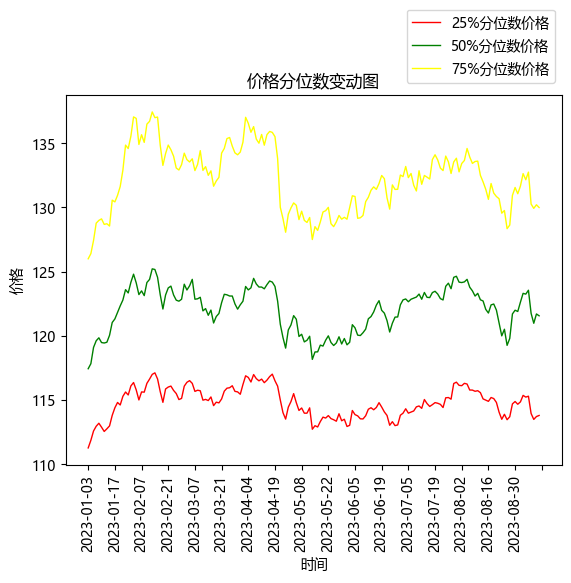

<Figure size 1500x1500 with 0 Axes>

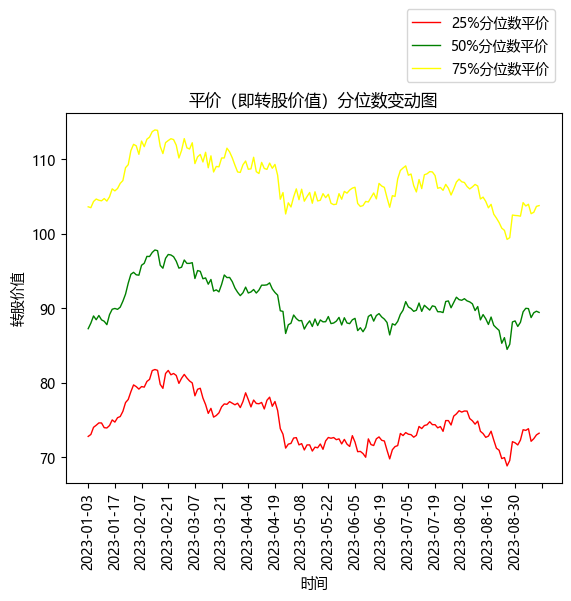

In [98]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt,log
from numpy import std

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

start_day = '2023-01-01'
a_df = A_DF[A_DF['date']>=start_day].copy()
c_df = C_DF[C_DF['date']>=start_day][['date','zi', 'gz2000']].copy()

x = list(C_DF[C_DF['date']>=start_day]['date'])

dp_25percent_values = a_df.groupby('date')['dp'].quantile(0.25)
dp_50percent_values = a_df.groupby('date')['dp'].quantile(0.5)
dp_75percent_values = a_df.groupby('date')['dp'].quantile(0.75)

csv_25percent_values = a_df.groupby('date')['csv'].quantile(0.25)
csv_50percent_values = a_df.groupby('date')['csv'].quantile(0.5)
csv_75percent_values = a_df.groupby('date')['csv'].quantile(0.75)


# 绘图
plt.figure(figsize=(15,15))
fig, ax = plt.subplots(1, 1)
plt.plot(x, dp_25percent_values, color='red', label="25%分位数价格",linewidth=1)
plt.plot(x, dp_50percent_values, color='green', label="50%分位数价格",linewidth=1)
plt.plot(x, dp_75percent_values, color='yellow', label="75%分位数价格",linewidth=1)
plt.xlabel("时间")
plt.ylabel("价格")
plt.title('价格分位数变动图')
# 图例显示
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.25))
# 设置打印的密度
tick_spacing = 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# 设置显示字体的大小
plt.tick_params(axis='both', labelsize=10)
# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)
# 显示图像
plt.show()


# 绘图
plt.figure(figsize=(15,15))
fig, ax = plt.subplots(1, 1)
plt.plot(x, csv_25percent_values, color='red', label="25%分位数平价",linewidth=1)
plt.plot(x, csv_50percent_values, color='green', label="50%分位数平价",linewidth=1)
plt.plot(x, csv_75percent_values, color='yellow', label="75%分位数平价",linewidth=1)
plt.xlabel("时间")
plt.ylabel("转股价值")
plt.title('平价（即转股价值）分位数变动图')
# 图例显示
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.3))
# 设置打印的密度
tick_spacing = 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# 设置显示字体的大小
plt.tick_params(axis='both', labelsize=10)
# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)
# 显示图像
plt.show()

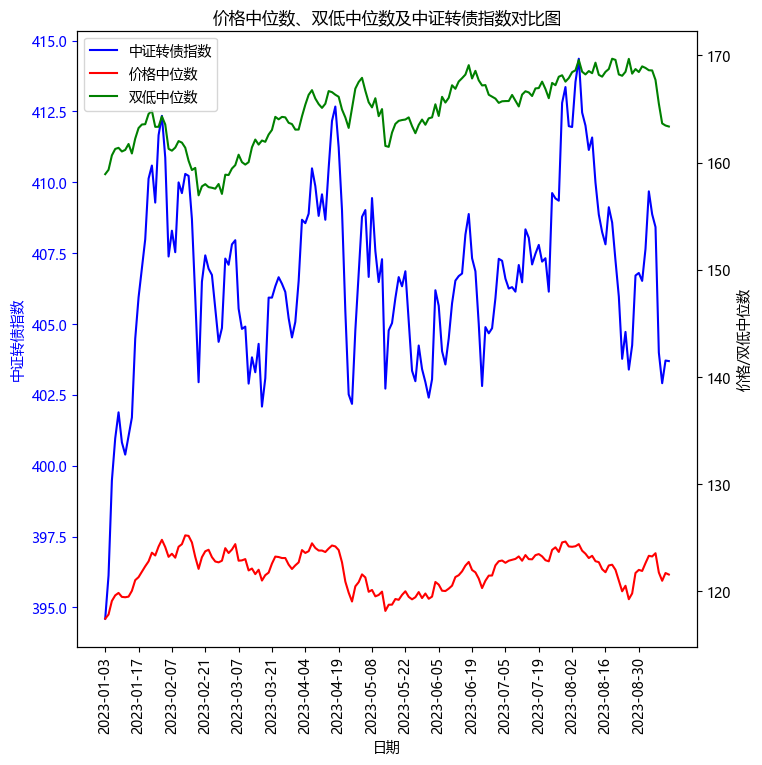

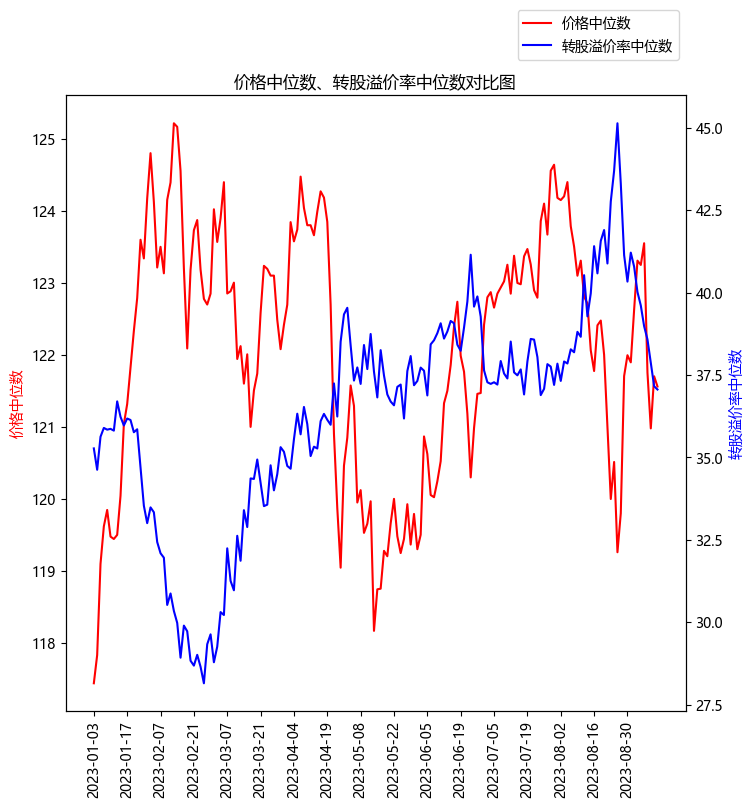

<Figure size 800x800 with 0 Axes>

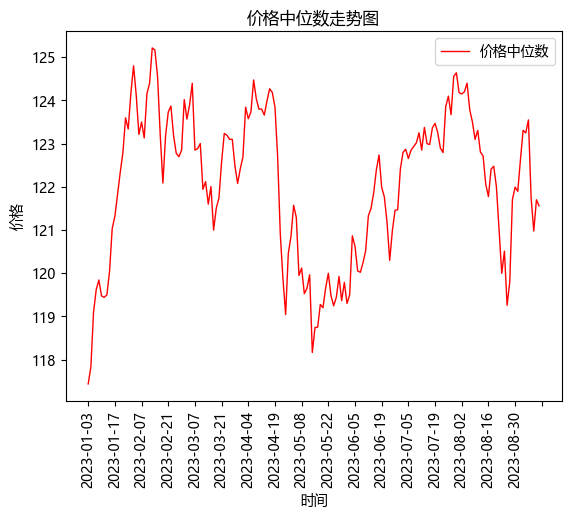

In [99]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt,log
from numpy import std

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

start_day = '2023-01-01'
a_df = A_DF[A_DF['date']>=start_day].copy()
c_df = C_DF[C_DF['date']>=start_day][['date','zi', 'gz2000']].copy()

x = list(C_DF[C_DF['date']>=start_day]['date'])
dp_median_values = a_df.groupby('date')['dp'].median()
dl_median_values = a_df.groupby('date')['dl'].median()
cpr_median_values = a_df.groupby('date')['cpr'].median()

zi_values = c_df.set_index('date')['zi']
gz2000_values = c_df.set_index('date')['gz2000']


# 创建一个包含多个子图的画布
fig, ax1 = plt.subplots(figsize=(8, 8))

# 绘制第一个数据集到第一个坐标轴
ax1.plot(x, zi_values, 'b-', label='中证转债指数')
ax1.set_xlabel('日期')
ax1.set_ylabel('中证转债指数', color='blue')
# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)
ax1.tick_params('y', colors='blue')


# 创建第二个坐标轴，共享X轴
ax2 = ax1.twinx()

# 绘制第二个数据集到第二个坐标轴
ax2.plot(x, dp_median_values, 'r-', label='价格中位数')
ax2.set_ylabel('价格/双低中位数', color='black')
ax2.tick_params('y', colors='black')


# 在同一张图上添加第三个数据集
plt.plot(x, dl_median_values, 'g-', label='双低中位数')

# 调整x轴刻度显示
new_xticks = x[::10]  # 自定义新的刻度位置
new_xticklabels = x[::10]  # 自定义新的刻度标签
plt.xticks(new_xticks, new_xticklabels)


# 显示图例和标题
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2)

plt.title('价格中位数、双低中位数及中证转债指数对比图')

# 显示图形
plt.show()




# 创建一个包含多个子图的画布
fig, ax1 = plt.subplots(figsize=(8, 8))

# 绘制第一个数据集到第一个坐标轴
ax1.plot(x, dp_median_values, 'r-', label='价格中位数')
ax1.set_ylabel('价格中位数', color='red')
ax1.tick_params('y', colors='red')

# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)
ax1.tick_params('y', colors='black')


# 创建第二个坐标轴，共享X轴
ax2 = ax1.twinx()

# 绘制第二个数据集到第二个坐标轴
ax2.plot(x, cpr_median_values, 'b-', label='转股溢价率中位数')
ax2.set_xlabel('日期')
ax2.set_ylabel('转股溢价率中位数', color='blue')


# 调整x轴刻度显示
new_xticks = x[::10]  # 自定义新的刻度位置
new_xticklabels = x[::10]  # 自定义新的刻度标签
plt.xticks(new_xticks, new_xticklabels)


# 显示图例和标题
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper right', bbox_to_anchor=(1.0, 1.15))

plt.title('价格中位数、转股溢价率中位数对比图')

# 显示图形
plt.show()


# 绘制单周净收益率曲线图
plt.figure(figsize=(8,8))
fig, ax = plt.subplots(1, 1)
plt.plot(x, dp_median_values, color='red', label="价格中位数",linewidth=1)
plt.xlabel("时间")
plt.ylabel("价格")
plt.title('价格中位数走势图')
# 图例显示
plt.legend()
# 设置打印的密度
# tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

# 设置显示字体的大小
plt.tick_params(axis='both', labelsize=10)
# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)
# 显示图像
plt.show()


In [100]:
df = A_DF[(A_DF['date']=='2023-09-06') & (A_DF['dp']>=150)].copy()
output_df = pd.merge(df[['bond_code', 'date', 'cpr', 'dp', 'bl', 'trt' ,'ytm','yl','dl','redeem_count']],B_DF[['bond_code','cn','sc','sn','cat1','cat2']],on='bond_code',how='left')
output_df.rename(columns={'date' : '日期',
                          'bond_code' : '可转债代码',
                          'dp' : '价格（收盘价全价）',
                          'cpr' : '转股溢价率',
                                'dl' : '双低',
                                'change':'涨跌幅',
                                'sn' : '正股名称',
                                'bl' : '债券余额（亿）',
                                'yl' : '剩余期限（年）',
                                'trt' : '换手率',
                                'ytm' : '到期收益率',
                         'cat1' : '申万一级',
                         'cat2' : '申万二级',
                         'cn' : '转债名称',
                         'sc' : '正股代码',
                         'redeem_count' : '强赎信息（精确，从集思录导出的）'},inplace=True)
output_df.to_excel('20230906收盘价大于150的转债.xlsx',index=False)

In [101]:
df = A_DF[A_DF['date']>='2023-08-30'].copy()
df.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
df['lastday_dp'] = df.groupby('bond_code')['dp'].shift(1)
df['last5day_dp'] = df.groupby('bond_code')['dp'].shift(5)
df['change'] = df['dp'] / df['lastday_dp'] - 1
df['weekly_change'] = df['dp'] / df['last5day_dp'] - 1
output_df = df[df['date']=='2023-09-06'][['bond_code','date','dp','lastday_dp','last5day_dp','change','weekly_change']].copy()
output_df.to_excel('匹配用途.xlsx',index=False)